In [1]:
%load HICREP.PY_DIRECTORY/hicrep.py
#!/usr/bin/env python # [1]
"""\
This script contains all the functions used to run Hi-C rep (doi: 10.1101/gr.220640.117) in the paper
"Dynamics of microcompartment formation at the mitosis-to-G1 transition".

Uses hicreppy: https://github.com/cmdoret/hicreppy

Original Author: Domenic Narducci
Modified By: Viraat Goel
"""

# Package imports
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import ndimage as ndi
import cooler as clr
from hicreppy.hicrep import h_train, genome_scc
import h5py
from itertools import product
from tqdm import tqdm

def read_cooler(cooler_path, resolution=250):
    """
    Simple function wrapper to read cooler file.
    """
    if clr.fileops.is_cooler(cooler_path):
        return clr.Cooler(cooler_path)
    elif clr.fileops.is_multires_file(cooler_path):
        return clr.Cooler(cooler_path + "::resolutions/" + str(int(resolution)))
    
def list_resolutions(cooler_path):
    """
    A helper function that reads possible resolutions from mcool file. 
    """
    with h5py.File(cooler_path, 'r') as f:
        print(f["1"].keys())
        return list(f['resolutions'].keys())

### Set global parameters

In [2]:
# Set some global parameters
max_dist = 1000000 #5000000
h_max = 12 #10
resolution = 5000 #50000

whitelist = ["chr2", "chr8", "chr9", "chr15"] # can pick a random sampling of chromosomes for speed

### Read mcools

In [3]:
file_path = "FILE_PATH" # path to mcools
mcool_files = ["MCOOL_FILE_1", "MCOOL_FILE_2", ...] # list of mcool files 
multi_coolers = [read_cooler(os.path.join(file_path, mcool_file), resolution) for mcool_file in mcool_files] # read mcool files at resolution
h_train_idxs = [0, 1]

### Find optimal h value

In [ ]:
optimal_h = h_train(multi_coolers[h_train_idxs[0]], multi_coolers[h_train_idxs[1]], max_dist, h_max, whitelist)

### Compute scc values

In [5]:
# compute downsampling value
cooler_sums = [cooler_file.info["sum"] for cooler_file in multi_coolers[:-1]]
downsampling_value = min(cooler_sums)

k = len(multi_coolers)
scc_mat = np.zeros((k, k))
for i, j in tqdm(product(range(k), range(k))):
    if i == j:
        scc_mat[i, j] = 1.0
    else:
        scc = genome_scc(multi_coolers[i], multi_coolers[j], max_dist, optimal_h, downsampling_value, whitelist)
        scc_mat[i, j] = scc
        scc_mat[j, i] = scc

225it [39:57, 10.65s/it]


### Plot correlation matrices

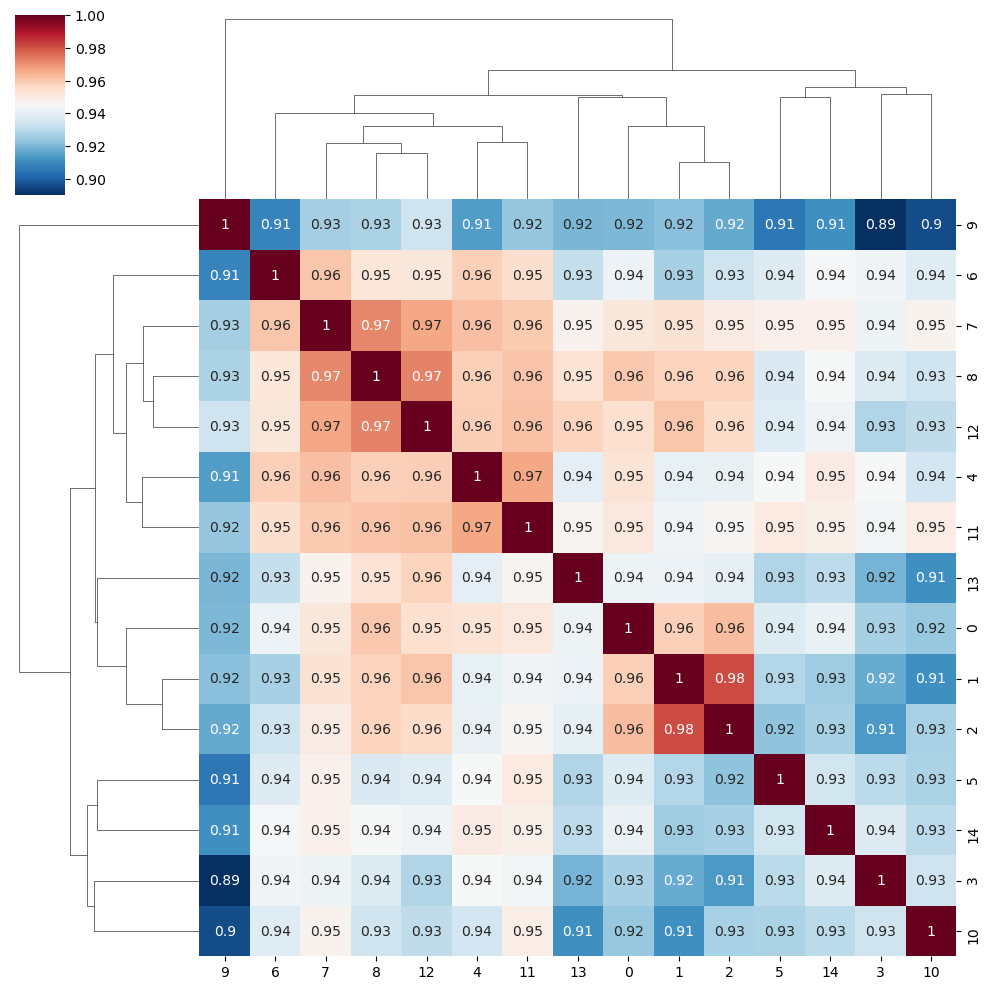

In [6]:
sns.clustermap(scc_mat, cmap= sns.color_palette("RdBu_r", as_cmap=True), annot=True)
plt.savefig('SAVE_DIRECTORY/FILE_NAME.svg', dpi=1200)